# Simulator Testing 0

The following code defines an ellipse corresponding to the path around the globe an orbit takes

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mplp
import scipy

#Some Absolute Constants
radius_polar = 6356752
radius_equatorial = 6378137
earth_eccentricity_squared = 6.694379e-3

For the following code, Cart2Spher converts Cartesian coordinate system $(x,y,z)$ into Spherical coordinate system $(r, \theta, \varphi)$, and Spher2Cart does the opposite.

In [47]:
def Cart2Spher(positions):
    sphercoords = np.zeros(positions.shape)
    xy2 = positions[:,0]**2 + positions[:,1]**2
    sphercoords[:,0] = np.sqrt(xy2 + positions[:,2]**2)
    sphercoords[:,1] = np.arctan2(np.sqrt(xy2), positions[:,2])
    sphercoords[:,2] = np.arctan2(positions[:,1],positions[:,0])
    return sphercoords

def Spher2Cart(positions):
    cartcoords = np.zeros(positions.shape)
    cartcoords[:,0] = positions[:,0] * np.sin(positions[:,1]) * np.cos(positions[:,2])
    cartcoords[:,1] = positions[:,0] * np.sin(positions[:,1]) * np.sin(positions[:,2])
    cartcoords[:,2] = positions[:,0] * np.cos(positions[:,1])
    return cartcoords

def Geodetic2Cart(positions):
    cartcoords = np.zeros(positions.shape)
    N_phi = radius_equatorial / (np.sqrt(1 - earth_eccentricity_squared*np.sin(positions[:,0])**2))
    cartcoords[:,0] = (N_phi + positions[:,2]) * np.cos(positions[:,0]) * np.cos(positions[:,1])
    cartcoords[:,1] = (N_phi + positions[:,2]) * np.cos(positions[:,0]) * np.sin(positions[:,1])
    cartcoords[:,2] = ((1-earth_eccentricity_squared)*N_phi + positions[:,2]) * np.sin(positions[:,0])
    return cartcoords

def Cart2Geodetic(positions):
    geodeticcoords = np.zeros(positions.shape)
    geodeticcoords[:,1] = np.arctan2(positions[:,1], positions[:,0])
    k_0 = 1/(1 - earth_eccentricity_squared)
    k = k_0
    p = np.sqrt(positions[:,0]**2 + positions[:,1]**2)
    for i in range(3):
        ci = ((p**2 + (1-earth_eccentricity_squared) * positions[:,2]**2 * k**2)**(3/2))/ (radius_equatorial * earth_eccentricity_squared)
        k = 1 + (p**2 + (1-earth_eccentricity_squared)*positions[:,2]**2*k**3)/(ci - p**2)
    
    geodeticcoords[:,2] = 1/earth_eccentricity_squared * (1/k - 1/k_0) * np.sqrt(p**2 + positions[:,2]**2 * k **2)
    geodeticcoords[:,0] = np.arctan2((k * positions[:,2]), p)
    return geodeticcoords

# def Cart2Geodetic2(positions):
#     geodeticcoords = np.zeros(positions.shape)
#     p = np.sqrt(positions[:,0]**2 + positions[:,1]**2)
#     F = 54*radius_polar**2 * positions[:,2]**2
#     G = p**2 + (1-earth_eccentricity_squared)*positions[:,2]**2 - earth_eccentricity_squared*(radius_equatorial**2-radius_polar**2)
#     c = earth_eccentricity_squared**2 * F * p**2 / (G**3)
#     s = np.cbrt(1 + c + np.sqrt(c**2 + 2*c))
#     k = s + 1 + 1/s
#     P = F/(3*k**2 * G**2)
#     Q = np.sqrt(1+2*earth_eccentricity_squared**2 * P)
#     r_0 = (-P*earth_eccentricity_squared*p)/(1 + Q) + np.sqrt(0.5*radius_equatorial**2 * (1 + 1/Q) - (P*(1-earth_eccentricity_squared)*positions[:,2])/(Q*(1+Q)) - 0.5*P*p**2)
#     U = np.sqrt((p-earth_eccentricity_squared*r_0)**2 + positions[:,2]**2)
#     V = np.sqrt((p-earth_eccentricity_squared*r_0)**2 + (1-earth_eccentricity_squared)*positions[:,2]**2)
#     z_0 = (radius_polar**2 * positions[:,2]) / (radius_equatorial * V)
#     geodeticcoords[:,2] = U * (1 - (radius_polar**2)/(radius_equatorial*V))
#     geodeticcoords[:,0] = np.arctan((positions[:,2] + (radius_equatorial**2 - radius_polar**2)/radius_polar**2 * z_0)/p)
#     geodeticcoords[:,1] = np.arctan2(positions[:,1],positions[:,0])
#     return geodeticcoords

In [52]:
test_vals = np.array([[4211e3,172.5e3,4780e3]])
print(Cart2Geodetic(test_vals))
print(Cart2Spher(test_vals))

[[8.48186875e-01 4.09412511e-02 6.36628461e+06]]
[[6.37265072e+06 7.22612782e-01 4.09412511e-02]]


In [258]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mplp
import scipy

class Ellipse:
    def __init__(self, centre, height, width, angle=0, tangent_veloc = True):
        self.x, self.y = centre
        self.w = width
        self.h = height
        self.theta = angle
    
    def r(self):
        """
        Defines the rotation matrix used to transform coordinates to 0-centred model
        """
        a = np.cos(self.theta)
        b = np.sin(self.theta)
        return np.array([[a,-b],[b,a]])
    
    def point_at_angle(self, angle):
        """
        Given an interior angle from an ellipse's centre, finds a point on the ellipse.
        """
        #Compute location of original point
        x_or = 0.5 * self.w * np.cos(angle)
        y_or = 0.5 * self.w * np.sin(angle)

        #rotate the point to the centred version of the ellipse
        rot_point = np.dot(self.r(), [x_or, y_or]) + [self.x, self.y]
        return rot_point
    
    def multi_points(self, locations):
        """
        Given an array of interior angles, this returns an array of positions on the ellipse.
        """
        points_array = []
        for loc in locations:
            points_array.append(self.point_at_angle(self,loc))
        return np.array(points_array)
    
    def closest_point(self, x, tol=1e-6, max_iter = 100):
        """
        Given a point outside the ellipse, and finds the point on the ellipse closest to this.
        It also returns the (smallest) distance between the point and the ellipse.
        """
        #First need to project the point to the space where ellipse centred at origin
        #Also, need to initialize the constants
        x = np.asarray(x)
        x2 = np.dot(self.r().T, x - [self.x, self.y])
        d0 = np.arctan2(x2[1], x2[0])
        a = 0.5 * self.w
        b = 0.5 * self.h
        #Check if points are in the interior of the ellipse
        if (x2[0] / a)**2 + (x2[1] / b)**2 <1:
            print("Initial point in interior!")
            return np.array(0), None
        
        iterations = 0
        ds = [d0]
        xs = []
        errors = [tol]

        while errors[-1] >= tol and iterations < max_iter:
            x1 = np.array([a * np.cos(ds[-1]), b * np.sin(ds[-1])])
            xs.append(x1)
            dx1dt = np.array([-a *np.sin(ds[-1]), b * np.cos(ds[-1])])
            dx1dt2 = np.array([-a * np.cos(ds[-1]), -b * np.sin(ds[-1])])
            dD2dt = 2*np.dot(dx1dt,(x1 - x2))
            dD2dt2 = 2*np.dot(dx1dt2,(x1-x2)) + 2*np.dot(dx1dt,dx1dt)
            ds.append(ds[-1] - dD2dt / dD2dt2)
            errors.append(np.abs(dD2dt/dD2dt2))
            iterations +=1
        
        x1 = np.array([a * np.cos(ds[-1]), b * np.sin(ds[-1])])
        dist = np.linalg.norm(x1 - x2)
        return dist, xs[-1]




In [278]:

class Earth_Ellipse:
    def __init__(self, incl_angle, rot_angle=0):
        self.elevation = incl_angle
        self.peak_longitude = rot_angle
        self.peak_latitude = -self.elevation+90.0
        
        self.ellipse_proj = Ellipse((0,0), 2*self.mindist, 2*radius_equatorial)
        

    







In [279]:
#Some quick tests
ellipse1 = Earth_Ellipse(0,0)

6356752.0


To Be Fixed: currently only keeps track of position for (0,0) centred ellipse coords! Needs to be fixed!

In [3]:
#Here are some global variables
M_e = 5.972e24
G = 6.673e-11


In [213]:
class Satellite:
    def __init__(self, mass, dragcoeff, init_position, init_veloc):
        """
        Begin by defining relevant attributes of a satellite, initial poisition,
        and set up arrays to track movement of satellite.
        """
        self.mass = mass
        self.altitude = None
        self.althist = None
        self.dragcoeff = dragcoeff
        self.position = init_position
        self.velocity = init_veloc
        self.poshist = [init_position]
        self.velochist = [init_veloc]

    def calcAltitude(self, ell: Ellipse):
        """
        Given a satellite and an ellipse, this performs the same calculation as the ellipse
        But more from a "Sattelite" POV
        """
        altitude, ground_pos = ell.closest_point(self.position)
        return altitude, ground_pos
    
    def calcGravAcc(self, ell: Ellipse):
        """
        Given a satellite's position, and accounting for non-zero-centred ellipses, computes
        The gravitational accelleration experienced by the satellite at that position
        """
        grav_acc = -G*M_e / np.linalg.norm(np.array(self.position) - np.array([ell.x, ell.y]))**2
        theta = np.arctan2(self.position[1], self.position[0])
        return np.array([grav_acc * np.cos(theta),grav_acc * np.sin(theta)])

    def calcDrag(self, altitude):
        """
        Ideally takes a reference from the physical parameters team to estimate drag
        """
        rho_0 = 1.225
        H = 8400.0
        A = np.pi * (self.dragcoeff / 2)**2

        cur_veloc = self.velochist[-1]
        rho = rho_0 * np.exp(-(altitude) / H)
        Fd_x = 0.5 * rho * cur_veloc[0]**2 * self.dragcoeff * A
        Fd_y = 0.5 * rho * cur_veloc[1]**2 * self.dragcoeff * A
        return np.array([Fd_x, Fd_y])
    
    def FEtimeStep(self, ell: Ellipse, dt):
        """
        Takes a timestep using Forward Euler
        """
        self.altitude, groundpos = self.calcAltitude(ell)
        if self.altitude <=0:
            return 
        drag_a = self.calcDrag(self.altitude) / self.mass
        grav_a = self.calcGravAcc(ell)
        tot_a = -drag_a + grav_a
        new_veloc = self.velocity + dt * tot_a
        self.velocity = new_veloc
        self.velochist.append(new_veloc)
        new_position = self.position + dt * self.velocity
        self.position = new_position
        self.poshist.append(new_position)
    
    def Gen_TimeStep(self, ell: Ellipse, dt, solver='RK45'):
        self.altitude, groundpos = self.calcAltitude(ell)
        if self.altitude <=0:
            return
        drag_a = self.calcDrag(self.altitude) / self.mass
        grav_a = self.calcGravAcc(ell)
        tot_a = drag_a + grav_a
        veloc_func = lambda t, v: tot_a
        veloc_sol = scipy.integrate.solve_ivp(veloc_func, [0,dt], self.velocity, method=solver, t_eval = [dt])
        new_veloc = [veloc_sol.y[0][0].tolist(),veloc_sol.y[1][0].tolist()]
        self.velocity = new_veloc
        self.velochist.append(new_veloc)
        pos_func = lambda t,x: self.velocity
        pos_sol = scipy.integrate.solve_ivp(pos_func, [0,dt], self.position, method=solver, t_eval=[dt])
        new_pos = [pos_sol.y[0][0].tolist(),pos_sol.y[1][0].tolist()]
        self.position = new_pos
        self.poshist.append(new_pos)
    
    def forecast(self, ell: Ellipse, dt=0.001, maxIter = 1000000, height_tol = 10000, simple_solver = False, solver = 'RK45'):
        """
        Runs the forward euler timestep until our altitude reaches 0. Can adjust dt as seen fit
        To be fixed: breaks when altitude drops below 10km or so.
        """
        self.altitude, groundpos = self.calcAltitude(ell)
        iter = 0

        if self.althist is None:
            self.althist = [self.altitude]
        
        if simple_solver == True:
            while self.altitude > height_tol and iter < maxIter:
                self.FEtimeStep(ell, dt)
                self.althist.append(self.altitude)
                #print(self.altitude)
                iter +=1
            return self.poshist, self.velochist, self.althist
        
        else:
            while self.altitude > height_tol and iter < maxIter:
                self.Gen_TimeStep(ell, dt, solver=solver)
                self.althist.append(self.altitude)
                #print(self.altitude)
                iter += 1
            return self.poshist, self.velochist, self.althist


In [214]:
sat1 = Satellite(3000, 2.2, [7378000, 0], [-7000,0])
ell1 = Ellipse((0,0), 6278000*2, 6378000*2)

In [209]:
#sat1.Gen_TimeStep(ell1, 0.1)

In [238]:
#print(ell1.closest_point([7378, 0]))
sat1 = Satellite(3000, 2.2, [0, 7378000], [7000,0])
ell1 = Ellipse((0,0), 6278000*2, 6378000*2)
dt = 0.1
poshist, velochist, althist = sat1.forecast(ell1, dt = dt, height_tol = 0)

Initial point in interior!


In [236]:
def orbitplotter(poshist, althist, ell1,dt):
    fig, axs = plt.subplots(1,2)
    axs.flatten()[0].plot(althist[0::int(1/dt)], label = "Altitude")
    axs.flatten()[0].set_xlabel("Time (s)")
    axs.flatten()[0].set_ylabel("Altitude (m)")
    axs.flatten()[0].set_title("Altitude of Satellite")
    axs.flatten()[0].legend()
    ellipse = mplp.Ellipse((ell1.x,ell1.y),ell1.w, ell1.h, angle = ell1.theta, fill=False, color = 'r')
    axs.flatten()[1].add_patch(ellipse)
    axs.flatten()[1].plot(poshist[:,0], poshist[:,1], label = "Position")
    axs.flatten()[1].set_aspect('equal')
    axs.flatten()[1].set_title("Path of Satellite (2D Projection)")
    #axs.flatten()[1].legend(loc='upper left')

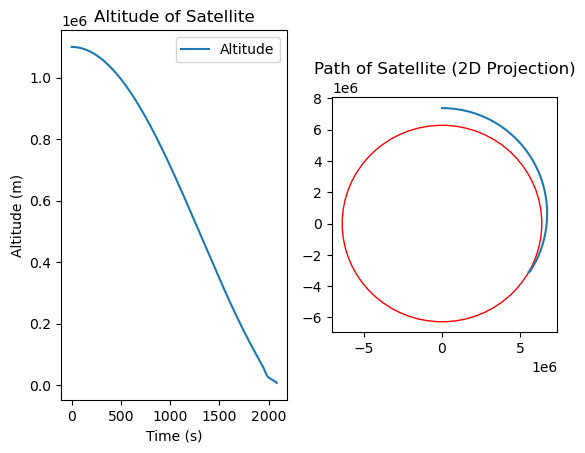

In [237]:
poshist = np.array(poshist)
orbitplotter(poshist, althist, ell1, dt)

In [ ]:
class radar:
    def __init__(self, lat_pos, long_pos):
        #TBD - Discuss in meeting